In [1]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = 'cuda'

# 1. Import Dataset

In [29]:
from torch.utils.data import DataLoader
from poc_data import PocDataset, display_sample


NUM_CASES = 2**10
BATCH_SIZE = 2**5

poc_raw_dataset = PocDataset(num_cases=NUM_CASES)
data_loader = DataLoader(dataset=poc_raw_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        pin_memory=True)

batch_data, batch_data_length, batch_event = next(iter(data_loader))

print(batch_data.shape)
print(batch_data_length.shape)
print(batch_event.shape)

torch.Size([32, 36, 5])
torch.Size([32, 1])
torch.Size([32, 1])


### Data Exploration

Length is 36, Event is 2
Length is 10, Event is 2
Length is 19, Event is 1
Length is 23, Event is 0


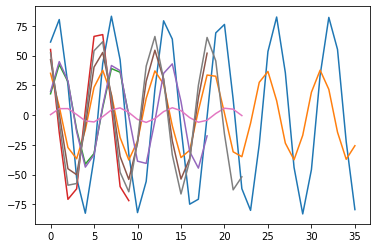

In [30]:
#Take a look at the longitudional data
display_sample(batch_data[0], batch_data_length[0], batch_event[0])
display_sample(batch_data[1], batch_data_length[1], batch_event[1])
display_sample(batch_data[2], batch_data_length[2], batch_event[2])
display_sample(batch_data[3], batch_data_length[3], batch_event[3])

### Test Sample

Length is 33, Event is 1


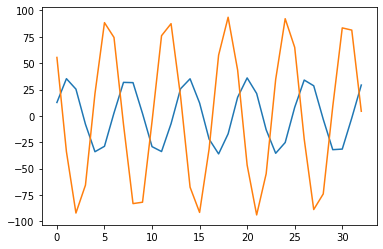

In [4]:
test_poc_raw_dataset = PocDataset(num_cases=1)
test_data_loader = DataLoader(dataset=test_poc_raw_dataset,batch_size=1,pin_memory=True)
test_batch_data, test_batch_data_length, test_batch_event = next(iter(test_data_loader))
display_sample(test_batch_data[0], test_batch_data_length[0], test_batch_event[0])

# 2. Hyperparameters

In [5]:
from torch.nn import MSELoss
from tqdm import trange, tqdm

from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

from dynamicDeepHit import EncoderRNN, AttnDecoderRNN, CauseSpecificSubnetwork, DynamicDeepHit
from losses import loss_1_batch, loss_2_batch, loss_3_batch

NUM_EPOCHS = 100

LEARNING_RATE_ENCODER = 0.0001
LEARNING_RATE_DECODER = 0.0001
LEARNING_RATE_CAUSESS = 0.00005

LOSS_1_AMPLIFIER = 1
LOSS_2_AMPLIFIER = 1
LOSS_3_AMPLIFIER = 0.1

RUN_VALIDATION_ROUND = False
VAL_NUM_CASES_RUNTIME = 2**3

input_size = 5
output_size = input_size
MAX_LENGTH = 36
NUM_CAUSES = 3
hidden_size_encoder = 512
hidden_size_attention = 512
fc_size_encoder = 512
SIGMA = 1

# 3. Defining The Model

In [6]:
# initialize model
encoder = EncoderRNN(input_size, hidden_size_encoder, fc_size_encoder).to(DEVICE)
decoder = AttnDecoderRNN(hidden_size_encoder, hidden_size_attention, output_size).to(DEVICE)
causess = CauseSpecificSubnetwork(hidden_size_encoder, input_size, MAX_LENGTH, NUM_CAUSES).to(DEVICE)
DDHT = DynamicDeepHit(encoder, decoder, causess, MAX_LENGTH, DEVICE)

# intialize optimizer
optimizer_encoder = Adam(encoder.parameters(), lr=LEARNING_RATE_ENCODER)
optimizer_decoder = Adam(decoder.parameters(), lr=LEARNING_RATE_DECODER)
optimizer_causess = Adam(causess.parameters(), lr=LEARNING_RATE_CAUSESS)
 
# initialize loss
writer = SummaryWriter()

# 4. Training the model

In [ ]:
from torch import autograd

# start training
for epoch in trange(NUM_EPOCHS):

  epoch_loss = 0

  for batch_number, data in enumerate(data_loader):

    batch_loss = 0

    optimizer_encoder.zero_grad()
    optimizer_decoder.zero_grad()
    optimizer_causess.zero_grad()

    batch_data, batch_data_length, batch_event = data
    batch_data = batch_data.to(DEVICE)
    batch_data_length = batch_data_length.to(DEVICE)
    batch_event = batch_event.to(DEVICE)
    
    output_batch, first_hitting_time_batch = DDHT(batch_data, batch_data_length)

    loss1 = LOSS_1_AMPLIFIER*loss_1_batch(first_hitting_time_batch, batch_event, batch_data_length, MAX_LENGTH)
    loss2 = LOSS_2_AMPLIFIER*loss_2_batch(first_hitting_time_batch, batch_event, batch_data_length, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)
    loss3 = LOSS_3_AMPLIFIER*loss_3_batch(output_batch, batch_data.detach())

    batch_loss = loss1 + loss2 + loss3
    batch_loss.backward()

    epoch_loss += batch_loss.detach()

    writer.add_scalar('train_loss1', loss1.item(), epoch*len(data_loader) + batch_number)
    writer.add_scalar('train_loss2', loss2.item(), epoch*len(data_loader) + batch_number)
    writer.add_scalar('train_loss3', loss3.item(), epoch*len(data_loader) + batch_number)

    optimizer_encoder.step()
    optimizer_decoder.step()
    optimizer_causess.step()

  if RUN_VALIDATION_ROUND:
    # validating round
    DDHT.eval()

    with torch.no_grad():
      val_poc_raw_dataset = PocDataset(num_cases=VAL_NUM_CASES_RUNTIME)
      val_data_loader = torch.utils.data.DataLoader(val_poc_raw_dataset,batch_size=VAL_NUM_CASES_RUNTIME)
      val_batch_data, val_data_length, val_batch_event = next(iter(val_data_loader))
      val_batch_data = val_batch_data.to(DEVICE)
      val_data_length = val_data_length.to(DEVICE)
      val_batch_event = val_batch_event.to(DEVICE)

      val_output_batch, val_first_hitting_time_batch = DDHT(val_batch_data, val_data_length)

      val_loss1 = LOSS_1_AMPLIFIER*loss_1_batch(val_first_hitting_time_batch, val_batch_event, val_data_length, MAX_LENGTH)/VAL_NUM_CASES_RUNTIME
      val_loss2 = LOSS_2_AMPLIFIER*loss_2_batch(val_first_hitting_time_batch, val_batch_event, val_data_length, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)/VAL_NUM_CASES_RUNTIME
      val_loss3 = LOSS_3_AMPLIFIER*loss_3_batch(val_output_batch, val_batch_data.detach())/VAL_NUM_CASES_RUNTIME

      writer.add_scalar('val_loss1', val_loss1.item(), epoch)
      writer.add_scalar('val_loss2', val_loss2.item(), epoch)
      writer.add_scalar('val_loss3', val_loss3.item(), epoch)
      writer.add_scalar('val_epoch_loss', val_loss1.item() + val_loss2.item() + val_loss3.item(), epoch)

    DDHT.train()
    # end validating round

  writer.add_scalar('train_epoch_loss', epoch_loss.item(), epoch)
  


# 4. Testing the Model

### Predicting the test sample

In [7]:
PATH = "C:/Users/marij/Desktop/THESIS ECO/DDHT/DDHT_pytorch/models/model_v6.pth"
#torch.save(DDHT.state_dict(), PATH)
DDHT.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Length is 7, Event is 2
tensor([[ 68.5292,  41.0034],
        [ 84.1865,   5.1927],
        [ 22.4430, -35.3922],
        [-59.9344, -43.4376],
        [-87.2084, -11.5467]])


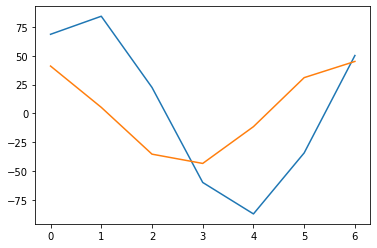

In [8]:
test_poc_raw_dataset = PocDataset(num_cases=1)
test_data_loader = DataLoader(dataset=test_poc_raw_dataset,batch_size=1,pin_memory=True)
test_batch_data, test_batch_data_length, test_batch_event = next(iter(test_data_loader))

display_sample(test_batch_data[0], test_batch_data_length[0], test_batch_event[0])
print(test_batch_data[0,:5,3:])

tensor([[ 83.3646,   3.7883],
        [ 21.4451, -34.7540],
        [-59.9242, -42.5374],
        [-87.6591, -11.1257],
        [-34.2167,  32.0590]], device='cuda:0', grad_fn=<SliceBackward>)
the model predicts at time 8 the event 1


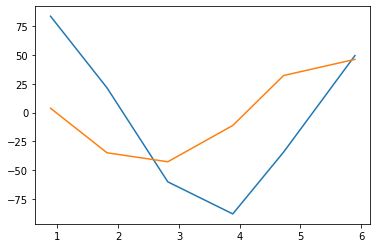

In [9]:
DDHT.eval();
test_encoder_output_vector, test_first_hitting_time = DDHT(test_batch_data.to(DEVICE), test_batch_data_length.to(DEVICE))
display_sample(test_encoder_output_vector[0].detach(), test_batch_data_length[0] - 1, test_batch_event[0], mute=True)
print(test_encoder_output_vector[0,:5,3:])

test_first_hitting_time_argmax = test_first_hitting_time.argmax().item()
model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH
print("the model predicts at time %d the event %d" % (model_tte_prediction, model_event_prediction))

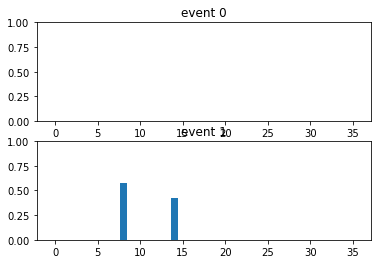

In [10]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.bar([i for i in range(MAX_LENGTH)], test_first_hitting_time.squeeze()[:MAX_LENGTH].cpu().detach().numpy())
ax2.bar([i for i in range(MAX_LENGTH)], test_first_hitting_time.squeeze()[MAX_LENGTH:].cpu().detach().numpy())
ax1.set_title("event 0")
ax2.set_title("event 1")
ax1.set_ylim([0,1]);
ax2.set_ylim([0,1]);

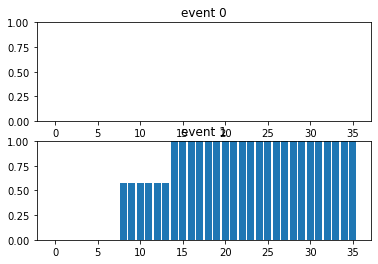

In [11]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.bar([i for i in range(MAX_LENGTH)], torch.cumsum(test_first_hitting_time.squeeze()[:MAX_LENGTH], dim=0).cpu().detach().numpy())
ax2.bar([i for i in range(MAX_LENGTH)], torch.cumsum(test_first_hitting_time.squeeze()[MAX_LENGTH:], dim=0).cpu().detach().numpy())
ax1.set_title("event 0")
ax2.set_title("event 1")
ax1.set_ylim([0,1]);
ax2.set_ylim([0,1]);

### Scoring our model - random test set

In [12]:
VAL_NUM_CASES = 2**6

val_poc_raw_dataset = PocDataset(num_cases=VAL_NUM_CASES)
val_data_loader = torch.utils.data.DataLoader(val_poc_raw_dataset,batch_size=2**6)
val_batch_data, val_batch_data_length, val_batch_event = next(iter(val_data_loader))
val_batch_data = val_batch_data.to(DEVICE)
val_batch_data_length = val_batch_data_length.to(DEVICE)
val_batch_event = val_batch_event.to(DEVICE)


In [13]:
DDHT.eval()

val_output_batch, val_first_hitting_time_batch = DDHT(val_batch_data, val_batch_data_length)
val_loss1 = LOSS_1_AMPLIFIER*loss_1_batch(val_first_hitting_time_batch, val_batch_event, val_batch_data_length, MAX_LENGTH)/VAL_NUM_CASES
val_loss2 = LOSS_2_AMPLIFIER*loss_2_batch(val_first_hitting_time_batch, val_batch_event, val_batch_data_length, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)/VAL_NUM_CASES
val_loss3 = LOSS_3_AMPLIFIER*loss_3_batch(val_output_batch, val_batch_data.detach())/VAL_NUM_CASES


print("val_loss1=", val_loss1.item())
print("val_loss2=", val_loss2.item())
print("val_loss3=", val_loss3.item())


val_loss1= 0.00026630843058228493
val_loss2= 0.056992579251527786
val_loss3= 0.0005408585420809686


Records:
* val_loss1= 0.09860126674175262
* val_loss2= 16.080060958862305
* val_loss3= 690.994384765625

### Scoring our model - fixed test set

sample has length 6
sample will experience event 1 at time 8
the model predicts the event 1 at time 6


<Figure size 864x1800 with 0 Axes>

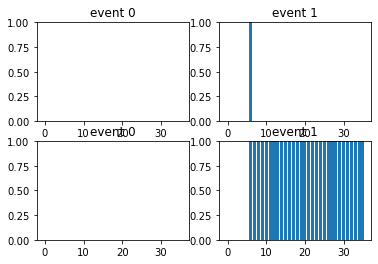

In [22]:
test_poc_raw_dataset = PocDataset(num_cases=1)
test_data_loader = poc_raw_dataset = PocDataset(num_cases=1, generate_meta=True, test_set=True, repays=False)
test_batch_data, test_batch_data_length, test_batch_event, test_meta = next(iter(test_data_loader))
test_batch_data = test_batch_data.unsqueeze(0).to(DEVICE)
test_batch_data_length = test_batch_data_length.unsqueeze(0).to(DEVICE)
test_batch_event = test_batch_event.unsqueeze(0).to(DEVICE)

DDHT.eval()

test_output, test_first_hitting_time = DDHT(test_batch_data, test_batch_data_length)
print("sample has length %d" % test_batch_data_length[0])
print("sample will experience event %d at time %d" % (test_meta['ground_truth_event'], test_meta['age']))

test_first_hitting_time_argmax = test_first_hitting_time.argmax().item()
model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH
print("the model predicts the event %d at time %d" % (model_event_prediction, model_tte_prediction))

plt.figure(figsize=(12,25))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
ax1.bar([i for i in range(MAX_LENGTH)], test_first_hitting_time.squeeze()[:MAX_LENGTH].cpu().detach().numpy())
ax2.bar([i for i in range(MAX_LENGTH)], test_first_hitting_time.squeeze()[MAX_LENGTH:].cpu().detach().numpy())
ax1.set_title("event 0")
ax2.set_title("event 1")
ax1.set_ylim([0,1]);
ax2.set_ylim([0,1]);

ax3.bar([i for i in range(MAX_LENGTH)], torch.cumsum(test_first_hitting_time.squeeze()[:MAX_LENGTH], dim=0).cpu().detach().numpy())
ax4.bar([i for i in range(MAX_LENGTH)], torch.cumsum(test_first_hitting_time.squeeze()[MAX_LENGTH:], dim=0).cpu().detach().numpy())
ax3.set_title("event 0")
ax4.set_title("event 1")
ax3.set_ylim([0,1]);
ax4.set_ylim([0,1]);